# Exploratory Data Analysis

We have used Python 3.10.12 for this project. Newer versions of Python does not work. 

The following libraries are required to run the code successfully:

*List*

It is also made aditional .py files holding different help functions. These are:
"`data_processing.py`", "`feature_generation.py`", `feature_selection.py`", "`model_evaluation.py`", "`data_pipeline.py`"

The machine learning modes that is testet are:
* XGBoost
* Catboost

Parts:
1. Libary import
2. Data extraction
3. Signal analysis
4. Feature analysis with correlation
5. Feature analysis with (...) K-means elns.
6. Feature analysis with XGBoost
7. Feature analysis with Catboost


## Libary import


In [110]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

import data_processing as dat_proc

from tabulate import tabulate
import warnings

%matplotlib inline



## Extractiong the data

In [111]:
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')

## Signal Analysis

Firsty the provided datasets are differend lengt, and closer inspection revile that they don't share all the time stamps. 
It's easy to se for set C that the label data training_c is not the same length as the signal data signal_c.

This is fixed in __data_processing.py__ by removing the time stamps that are not shared between the two datasets. With the function `data_length_matching`

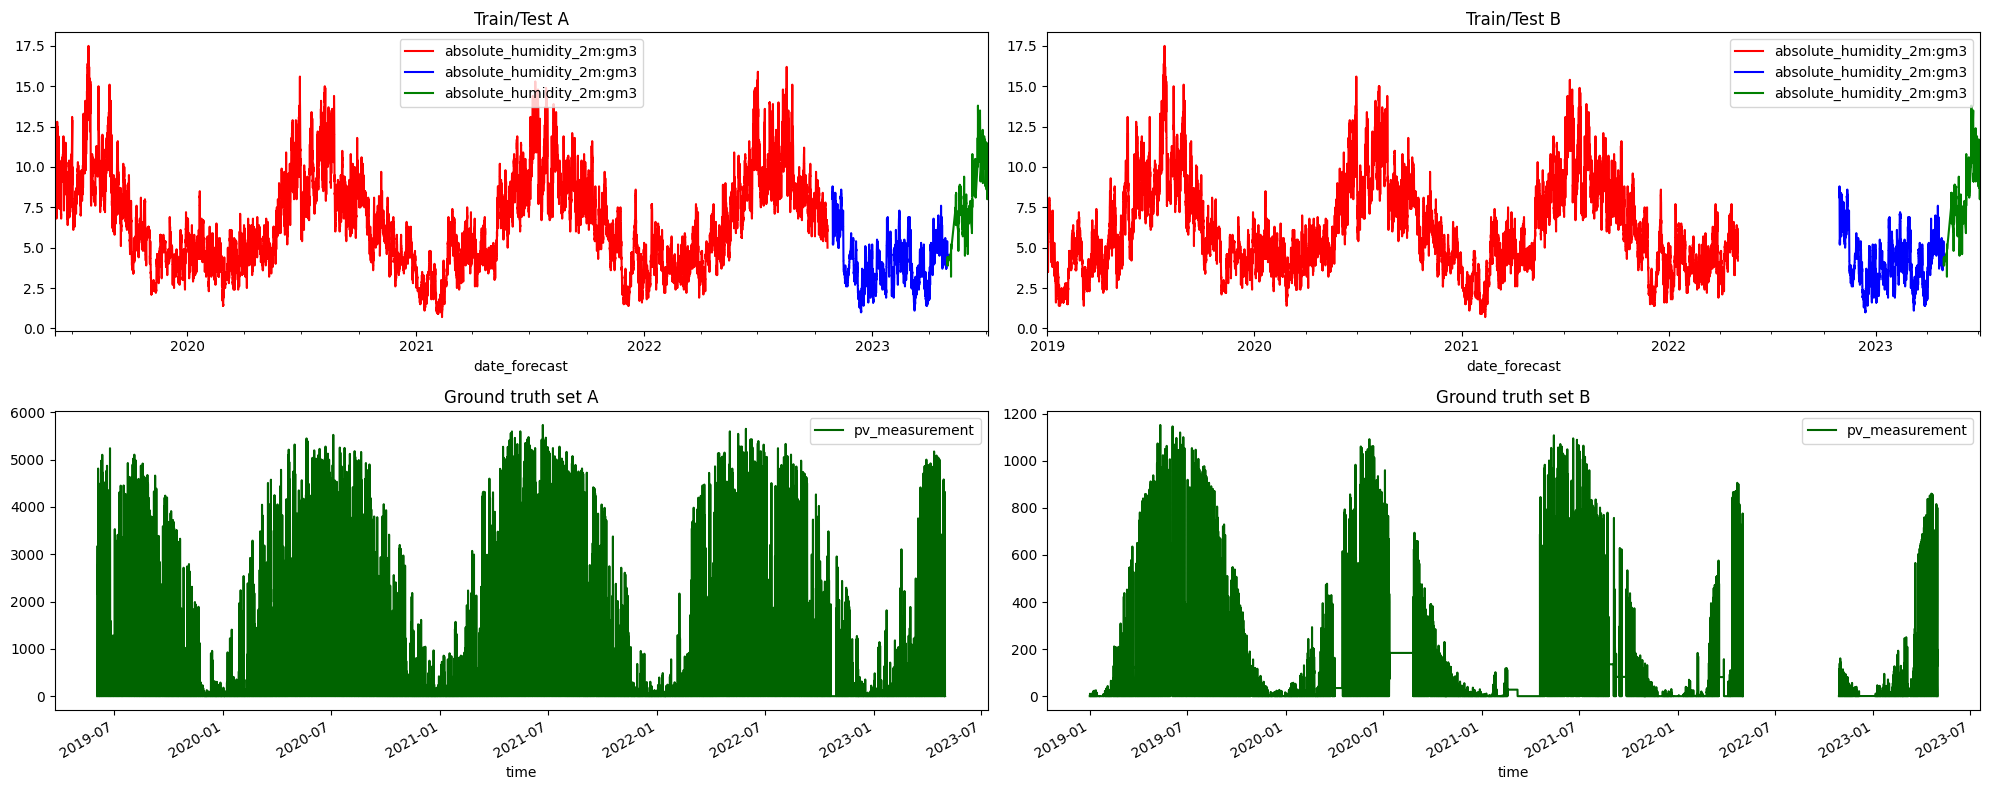

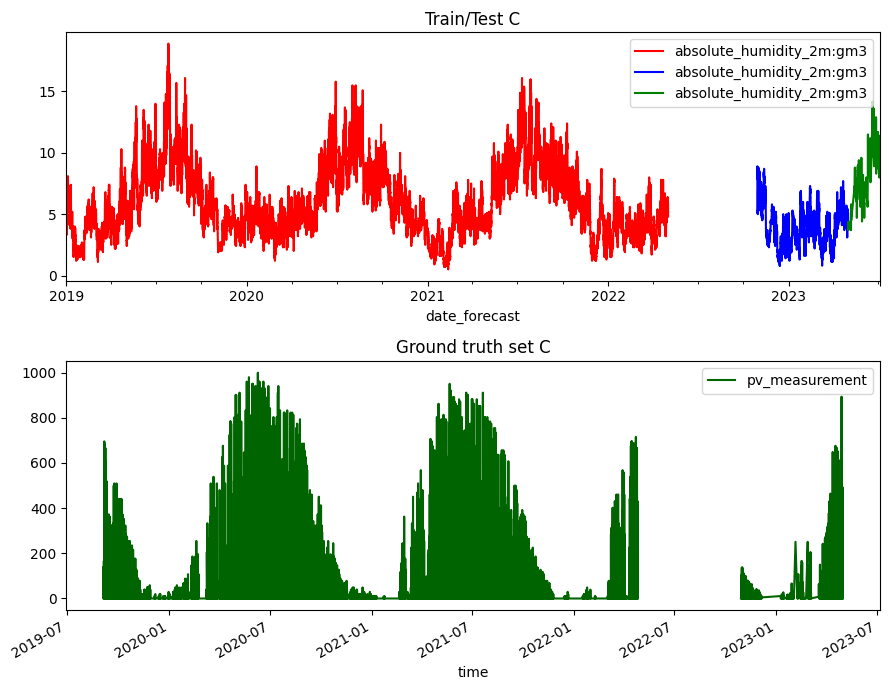

In [112]:
# Set display options
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

# Set plot options
plt.rcParams['figure.figsize'] = [20, 8]  
fig, axs = plt.subplots(2, 2)  # Adjust height ratios

# Plotting a single feature for all the sets to understand the data better
feature_name = 'absolute_humidity_2m:gm3'

# Plotting Train/Test & Ground Truth for set A
X_train_observed_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0,0], title='Train/Test A', color='red')
X_train_estimated_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0,0], color='blue')
X_test_estimated_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0,0], color='green')
train_a[['time', 'pv_measurement']].set_index('time').plot(ax=axs[1,0], title='Ground truth set A', color='darkgreen')

# Plotting Train/Test & Ground Truth for set B
X_train_observed_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0,1], title='Train/Test B', color='red')
X_train_estimated_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0,1], color='blue')
X_test_estimated_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0,1], color='green')
train_b[['time', 'pv_measurement']].set_index('time').plot(ax=axs[1,1], title='Ground truth set B', color='darkgreen')
plt.tight_layout()

plt.rcParams['figure.figsize'] = [9, 7]  
fig, axs = plt.subplots(2, 1)  # Adjust height ratios
# Plotting Train/Test & Ground Truth for set C
X_train_observed_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test C', color='red')
X_train_estimated_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], color='blue')
X_test_estimated_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], color='green')
train_c[['time', 'pv_measurement']].set_index('time').plot(ax=axs[1], title='Ground truth set C', color='darkgreen')

plt.tight_layout()

## Feature Extracting 

We started by figuring out what features could be usefull for the machine learning models.

First we at the correlation between pv_measured and the other features. Importaint note her is that altho some of the is higly correlated doesn't nessesarly mean that they are usefull for the model. (This narrative was also strengtend throug ploting some of the features with high correlation)
A Postive correlation means that the compaired features a.re moving in the same direction, and a negative one means that they are moving in the opposite direction. Our first thouth was that the features with the highest correlation would be the most usefull, but then we tried feature selection instead. 



### Help functions for correlation

In [113]:
# Beregn kovarians for hver funksjon med utgangsvariabelen
def correlation_calc(train, obs, features_list):
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    train = train.fillna(0)
    obs = obs.fillna(0)

    correlations = {}
    for feature in features_list:
        covariance = obs[feature].corr(train['pv_measurement'])
        correlations[feature] = covariance

    # Opprett en liste med kovariansverdiene
    corr_data = []
    for feature, corl in correlations.items():
        corr_data.append([feature, corl])
    return correlations, corr_data

def see_corre_text(correlations):
    print('This is the correlation between each feature and the output variable: \n')
    corr_data = [[feature, correlation] for feature, correlation in correlations.items()]
    table = tabulate(corr_data, headers=['Feature', 'Correlation'], tablefmt='pipe')
    print(table)

def see_corre_bar(correlations):
    correlation_df = pd.DataFrame(correlations.items(), columns=['Feature', 'Correlation']) # Create df to store the correlations
    correlation_df = correlation_df.sort_values(by='Correlation', ascending=False) # Sort the DataFrame by correlation values

    # Create a bar plot to visualize the correlations
    plt.figure(figsize=(12, 10))
    sns.barplot(x='Correlation', y='Feature', data=correlation_df, orient='h', hue='Feature', palette='viridis', legend=False)
    plt.title('Correlation between pv_measurement and Features in obs')
    plt.xlabel('Correlation')
    plt.ylabel('Feature')
    plt.show()

### The Correlation

In [114]:
# print(X_train_observed_a.columns.values)
cor_features = ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m',
    'clear_sky_energy_1h:J', 'clear_sky_rad:W', 'cloud_base_agl:m',
    'dew_or_rime:idx', 'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J',
    'direct_rad:W', 'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m',
    'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
    'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
    'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
    'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p', 'rain_water:kgm2',
    'relative_humidity_1000hPa:p', 'sfc_pressure:hPa', 'snow_density:kgm3',
    'snow_depth:cm', 'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
    'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
    't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
    'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms']

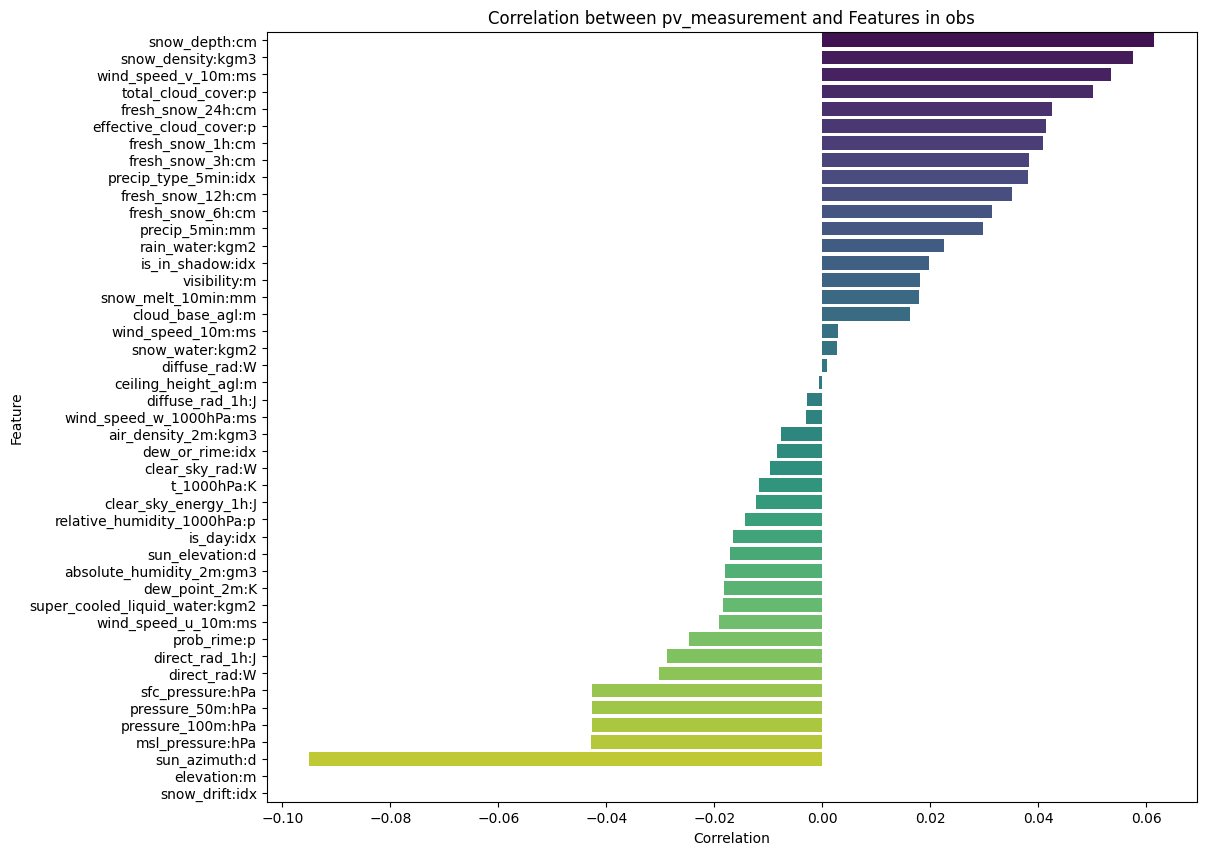

In [115]:
tr_a, obs_a = dat_proc.data_length_matching(train_a, X_train_observed_a)
correlations, corr_data = correlation_calc(train_a, obs_a, cor_features)
see_corre_bar(correlations)